# Exploratry Data Analysis and Prediction Model for Cuisine Prediction

![](https://timesofoman.com/uploads/images/2017/10/04/746773.jpg)

## 1. Import 

### 1.1. Import Library

In [1]:
# System
import sys
import os
from os import path
import argparse

# Time
import time
import datetime

# Numerical Data
import random
from random import shuffle
import numpy as np 
import pandas as pd

# Tools
import itertools
from glob import glob

# NLP
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight as cw

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

# Evaluation Matrics
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Graph/ Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import json

np.random.seed(7)

lemmatizer = WordNetLemmatizer()
stemmer=SnowballStemmer('english')

%matplotlib inline

# Input data
print(os.listdir("../input"))

['sample_submission.csv', 'test.json', 'train.json']


## 2. Read Data

In [2]:
def read_data(path):
    return json.load(open(path)) 

def generate_text(data):
    text_data = [" ".join(x['ingredients']).lower() for x in data]
    return text_data 

def prep(t):
    for i in range(len(t)):
        text = t[i].lower().split(" ")
        text = [re.sub("[^a-zA-Z\s+]", "", t) for t in text]
        text = [re.sub("\s+", "-", t) for t in text]
        text = [t.strip() for t in text if t.strip()!=""]
        t[i] = " ".join(text)
    return t


def get_tok(text):
    t = []
    for i in text:
        t.extend(i.split(" "))
    t = list(set(t))
    return t

In [3]:
train = read_data('../input/train.json')
test = read_data('../input/test.json')

## 2. Preprocess Data

In [4]:
test_id = [doc['id'] for doc in test]
train_text = generate_text(train)
test_text = generate_text(test)
target = [doc['cuisine'] for doc in train]

In [5]:
train_text = prep(train_text)
test_text = prep(test_text)

## 3. Visualization

In [6]:
def get_params():
    params = {'legend.fontsize' : 'Large',
              'figure.figsize'  : (16,8),
              'axes.labelsize'  : 'x-large',
              'axes.titlesize'  : 'xx-large',
              'xtick.labelsize' : 'Large',
              'ytick.labelsize' : 'Large'}
    return params

### 3.1. Showing Recipe Count per Cuisine

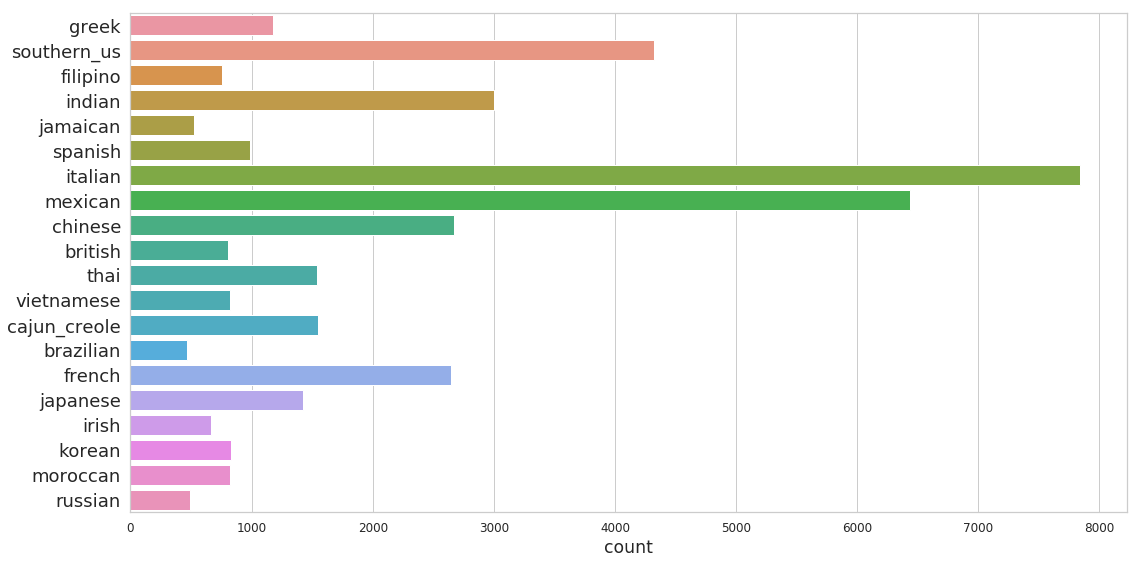

In [7]:
# sns.set(style="ticks")
sns.set(style="whitegrid")
plt.figure(figsize=(16,8))
params = get_params()
plt.rcParams.update(params)
plt.tick_params(labelsize=12)
sns.countplot(y=target)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## 4. Preprocessing 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_text, target, test_size=.2)

In [9]:
vect = TfidfVectorizer()

vect.fit(X_train)

X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

test_text_df = vect.transform(test_text)

In [10]:
lbl_enc = LabelEncoder()
y_train_label = lbl_enc.fit_transform(y_train)

lbl_enc_test = LabelEncoder()
y_test_label = lbl_enc_test.fit_transform(y_test)

## 5. Training 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# parameters = {'C': np.arange(1, 100, 5)}
model = LinearSVC()
# model = LogisticRegression(multi_class='multinomial')
# model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# model = SVC()

model = OneVsRestClassifier(model)
# model = BaggingRegressor(model, n_estimators=100)
# model = GridSearchCV(model, parameters, n_jobs=-1, verbose=2, cv=3)

print(cross_val_score(model, X_train_df, y_train_label, scoring='accuracy', n_jobs=-1, cv=3)) 

model.fit(X_train_df, y_train_label)
model.score(X_test_df, y_test_label)

[0.78413267 0.78380162 0.78      ]


0.7864236329352609

## 6. Prediction 

In [12]:
y_pred = model.predict(test_text_df)
y_pred = lbl_enc_test.inverse_transform(y_pred)

In [13]:
df = pd.DataFrame({'cuisine' : y_pred , 'id' : test_id }, columns=['id', 'cuisine'])
df.to_csv('submission.csv', index = False)
df.head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [14]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier

# clf1 = LogisticRegression()
# clf1 = OneVsRestClassifier(clf1, n_jobs=-1)

# clf2 = model = LinearSVC()
# clf2 = OneVsRestClassifier(clf2, n_jobs=-1)


# model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)])


# # model = AdaBoostClassifier(n_estimators=100)
# r = np.arange(0.1, 1, 0.1)

# parameters = {'C': r}

# # model = GridSearchCV(model, parameters, n_jobs=-1, verbose=2, cv=3)

# model.fit(X_train_df, y_train_label)
# # print(cross_val_score(model, X_train_df, y_train_label, scoring='accuracy', n_jobs=-1, cv=3)) 

# Reference
1. [Shivam Bansal's TF-IDF with OvR SVM : What's Cooking](https://www.kaggle.com/shivamb/tf-idf-with-ovr-svm-what-s-cooking)

# Image Credit
1. https://timesofoman.com/uploads/images/2017/10/04/746773.jpg